# Basic Data Manipulation

In [2]:
# Import Dependencies
import pandas_datareader.data as web
import pandas as pd
import numpy as np
# configure ldconf or environment variable
# export LD_LIBRARY_PATH=/usr/local/lib:$LD_LIBRARY_PATH
from talib import RSI, BBANDS, EMA
import matplotlib.pyplot as plt


In [5]:
# Download Data
start = '2009-08-14'
end = '2021-02-19'

symbol = 'VNM'
max_holding = 100
# set IEX_API_KEY= before using iex
# To suppress potential SSL error
# export CURL_CA_BUNDLE=""
vnm = web.DataReader(name=symbol, data_source='iex', start=start, end=end)
# set QUANDL_API_KEY before using quandl
# caveat: didn't find US ETF from quandl
# price = web.DataReader(name=symbol, data_source='quandl', start=start, end=end)
%store vnm

Stored 'vnm' (DataFrame)


In [3]:
# Restore fetched data to avoid calling API too much
%store -r vnm
vnm.tail(1)


,open,high,low,close,volume
date,,,,,
2021-02-19,18.44,18.45,18.2,18.39,428126


In [13]:
vnm.index = pd.to_datetime(vnm.index)
close = vnm['close']

start = '2009-08-14'
end = '2021-02-19'
# Getting all weekdays between 01/01/2000 and 12/31/2016
all_weekdays = pd.date_range(start=start, end=end, freq='B')

# How do we align the existing prices in adj_close with our new set of dates?
# All we need to do is reindex close using all_weekdays as the new index
close = close.reindex(all_weekdays)

# Reindexing will insert missing values (NaN) for the dates that were not present
# in the original set. To cope with this, we can fill the missing by replacing them
# with the latest available price for each instrument.
close = close.fillna(method='ffill')

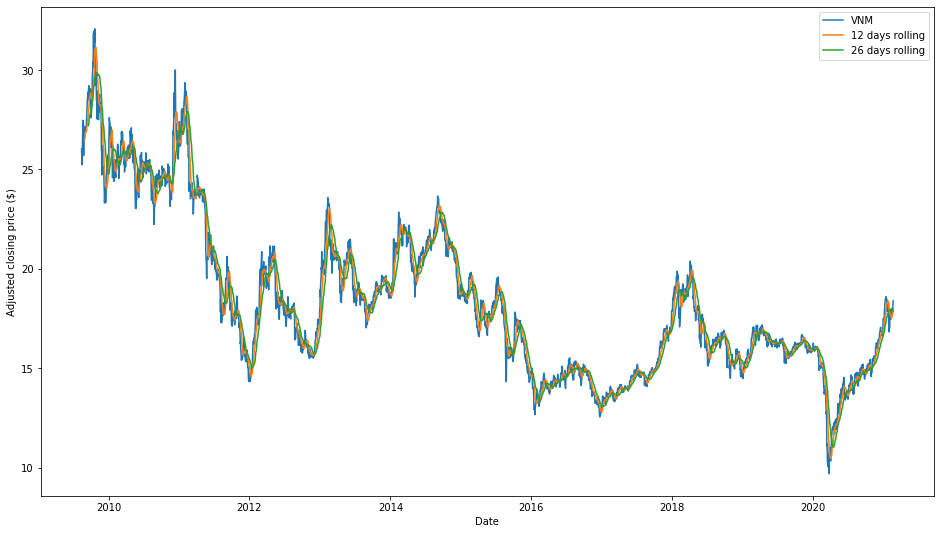

In [46]:
# Calculate the 20 and 100 days moving averages of the closing prices
short_rolling = close.rolling(window=12).mean()
long_rolling = close.rolling(window=26).mean()

# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(close.index, close, label='VNM')
ax.plot(short_rolling.index, short_rolling, label='12 days rolling')
ax.plot(long_rolling.index, long_rolling, label='26 days rolling')

ax.set_xlabel('Date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()

In [45]:
close.dropna()
close.describe()
daily_return = close.pct_change(1).rename('dRet')
log_return = np.log(close).diff().rename('logRet')
aVol = log_return.rolling(21).std().rename('vol')*(252**0.5)
vnm_vol = pd.concat([close, log_return, daily_return, aVol], axis=1)
vnm_vol.tail(10)

,close,logRet,dRet,vol
2021-02-08,17.47,-0.025432,-0.025112,0.285539
2021-02-09,17.75,0.015900,0.016027,0.291628
2021-02-10,17.80,0.002813,0.002817,0.291110
2021-02-11,17.93,0.007277,0.007303,0.292889
2021-02-12,18.01,0.004452,0.004462,0.293409
2021-02-15,18.01,0.000000,0.000000,0.293350
2021-02-16,17.83,-0.010045,-0.009994,0.294925
2021-02-17,18.08,0.013924,0.014021,0.276911
2021-02-18,18.20,0.006615,0.006637,0.273276
2021-02-19,18.39,0.010385,0.010440,0.271096


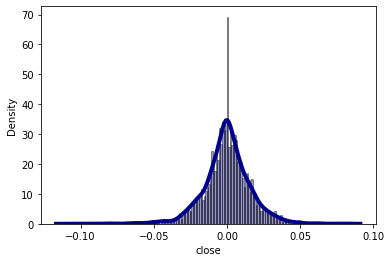

In [20]:
import seaborn as sns
sns.distplot(daily_return, hist=True, kde=True, 
             bins=int(180), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})